In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

import pennylane as qml
import matplotlib.pyplot as plt
import pickle, os

# ------------------ PARAMETERS ------------------
TRAIN_CSV = "heart_train.csv"
TEST_CSV = "heart_test.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.3
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 16
EPOCHS = 30           # reduced for speed
LEARNING_RATE = 5e-4
N_LAYERS = 2          # quantum circuit layers
MAX_QUBITS = 8        # limit for simulation


In [14]:
# ------------------ 1) Data Loading ------------------
train_df = pd.read_csv(TRAIN_CSV)

cols_to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
le_dict = {}
for col in cols_to_encode:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    le_dict[col] = le

X = train_df.drop('HeartDisease', axis=1)
y = train_df['HeartDisease']

# Split train/val/test
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=TEST_SIZE,
                                                          random_state=RANDOM_STATE, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5,
                                                random_state=RANDOM_STATE, stratify=y_valtest)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [16]:
# ------------------ 2) Qubit setup ------------------
n_features = X_train.shape[1]
n_qubits = min(n_features, MAX_QUBITS)

if n_features > n_qubits:
    pca = PCA(n_components=n_qubits, random_state=RANDOM_STATE)
    X_train_q = pca.fit_transform(X_train)
    X_val_q = pca.transform(X_val)
    X_test_q = pca.transform(X_test)
else:
    X_train_q = X_train
    X_val_q = X_val
    X_test_q = X_test

print(f"Using {n_qubits} qubits, input dim to quantum layer: {X_train_q.shape[1]}")


Using 8 qubits, input dim to quantum layer: 8


In [17]:
# ------------------ 3) Quantum circuit ------------------
dev = qml.device("default.qubit", wires=n_qubits)

def variational_circuit(params, x=None):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    for l in range(params.shape[0]):
        for q in range(n_qubits):
            qml.RX(params[l, q, 0], wires=q)
            qml.RY(params[l, q, 1], wires=q)
            qml.RZ(params[l, q, 2], wires=q)
        for q in range(n_qubits):
            qml.CNOT(wires=[q, (q+1) % n_qubits])

@qml.qnode(dev, interface='tf')
def qnode_tf(inputs, weights):
    variational_circuit(weights, x=inputs)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]



In [22]:
class QNNLayer(tf.keras.layers.Layer):
    def __init__(self, n_qubits, n_layers, **kwargs):
        super().__init__(**kwargs)
        init_weights = np.random.uniform(low=0, high=2*np.pi, size=(n_layers, n_qubits, 3))
        self.weights_var = tf.Variable(init_weights, dtype=tf.float32, trainable=True)
        self.n_qubits = n_qubits
        self.n_layers = n_layers

    def call(self, inputs):
        return tf.map_fn(
            lambda x: tf.cast(qnode_tf(x, self.weights_var), tf.float32),
            inputs,
            fn_output_signature=tf.TensorSpec(shape=(self.n_qubits,), dtype=tf.float32)
        )

In [23]:

# ------------------ 5) Build hybrid model ------------------
inp = Input(shape=(X_train_q.shape[1],))
x = Dense(32, activation='relu')(inp)
x = Dense(n_qubits, activation='linear')(x)
x = QNNLayer(n_qubits=n_qubits, n_layers=N_LAYERS)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(1, activation='sigmoid')(x)

hybrid_model = Model(inputs=inp, outputs=out)
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                     loss='binary_crossentropy', metrics=['accuracy'])

hybrid_model.summary()



Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ qnn_layer_2 (QNNLayer)               │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 713 (2.79 KB)

 Trainable params: 713 (2.79 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:

# ------------------ 6) Train ------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = hybrid_model.fit(X_train_q, y_train, validation_data=(X_val_q, y_val),
                           epochs=EPOCHS, batch_size=BATCH_SIZE,
                           callbacks=[early_stop], verbose=1)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.5504 - loss: 0.6903 - val_accuracy: 0.5545 - val_loss: 0.6872
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5639 - loss: 0.6857 - val_accuracy: 0.5545 - val_loss: 0.6827
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6081 - loss: 0.6778 - val_accuracy: 0.5545 - val_loss: 0.6756
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6402 - loss: 0.6721 - val_accuracy: 0.7636 - val_loss: 0.6658
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7064 - loss: 0.6618 - val_accuracy: 0.7727 - val_loss: 0.6517
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7838 - loss: 0.6382 - val_accuracy: 0.7909 - val_loss: 0.6336
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7954 - loss: 0.6159 - val_accuracy: 0.7818 - val_loss: 0.6129
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8207 - loss: 0.5933 - val_accuracy: 0.7818 -

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 537ms/step
Accuracy: 0.8198198198198198
F1: 0.84375
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        50
           1       0.81      0.89      0.84        61

    accuracy                           0.82       111
   macro avg       0.82      0.81      0.82       111
weighted avg       0.82      0.82      0.82       111

Confusion Matrix:
 [[37 13]
 [ 7 54]]


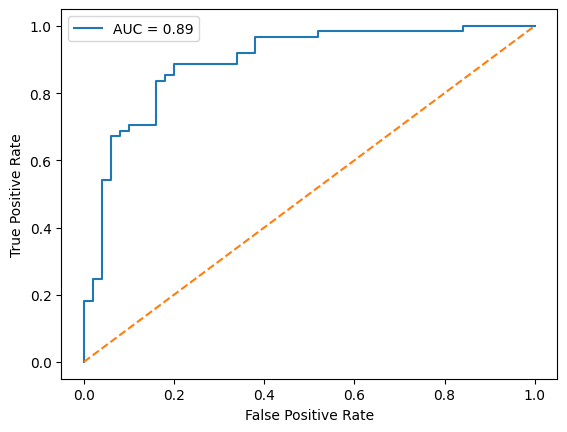

In [25]:

# ------------------ 7) Evaluate ------------------
y_pred_prob = hybrid_model.predict(X_test_q).ravel()
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("F1:", f1_score(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", cm)

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [26]:

# ------------------ 8) Predict on final test set ------------------
test_df = pd.read_csv(TEST_CSV)
ids = test_df["id"] if "id" in test_df.columns else pd.Series(range(len(test_df)))

for col in cols_to_encode:
    test_df[col] = le_dict[col].transform(test_df[col].astype(str))

X_final_test = test_df.drop(columns=["id"], errors="ignore")
X_final_test = scaler.transform(X_final_test)

if n_features > n_qubits:
    X_final_test_q = pca.transform(X_final_test)
else:
    X_final_test_q = X_final_test

test_pred_prob = hybrid_model.predict(X_final_test_q).ravel()
test_pred_class = (test_pred_prob > 0.5).astype(int)

submission = pd.DataFrame({"id": ids, "HeartDisease": test_pred_class})
submission.to_csv("submission_qnn.csv", index=False)
print("✅ submission_qnn.csv saved")



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
✅ submission_qnn.csv saved


In [30]:
# ------------------ 9) Save scaler + weights ------------------os.makedirs('model_qnn', exist_ok=True)
with open('model_qnn/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

hybrid_model.save_weights('model_qnn/model.weights.h5')
print("✅ Model and scaler saved in model_qnn/")


✅ Model and scaler saved in model_qnn/
